# Laser Ablation Analysis Notebook

This notebook shows an example of the laser analysis workflow used in the paper:

RhoA mediates stress fiber strain site recognition by the LIM protein testin<br>
Sala S, Oakes PW<br>
2021

https://www.biorxiv.org/content/10.1101/2021.01.21.427693v1

See Supplemental Figure 1

In [1]:
import os                                                      # making and managing directories
import glob as glob                                            # grabbing file names
import numpy as np                                             # basic math
import skimage.io as io                                        # reading in images
%matplotlib notebook                                           
import matplotlib.pyplot as plt                                # for plotting
import pandas as pd                                            # for data storage
import cv2                                                     # for filtering vector fields
from skimage.transform import rotate                           # for rotating frequency map

from Sala_testin_LA_analysis import *

# import warnings
# warnings.filterwarnings('ignore')


In [2]:
file_list_LA_c0 = sorted(glob.glob('LA_example/*LA*C0.tif'))

for file in file_list_LA_c0:
    print(file)

LA_example/LIM 1-2-3 LA 9_XY1591840029_Z0_T000_C0.tif


<IPython.core.display.Javascript object>


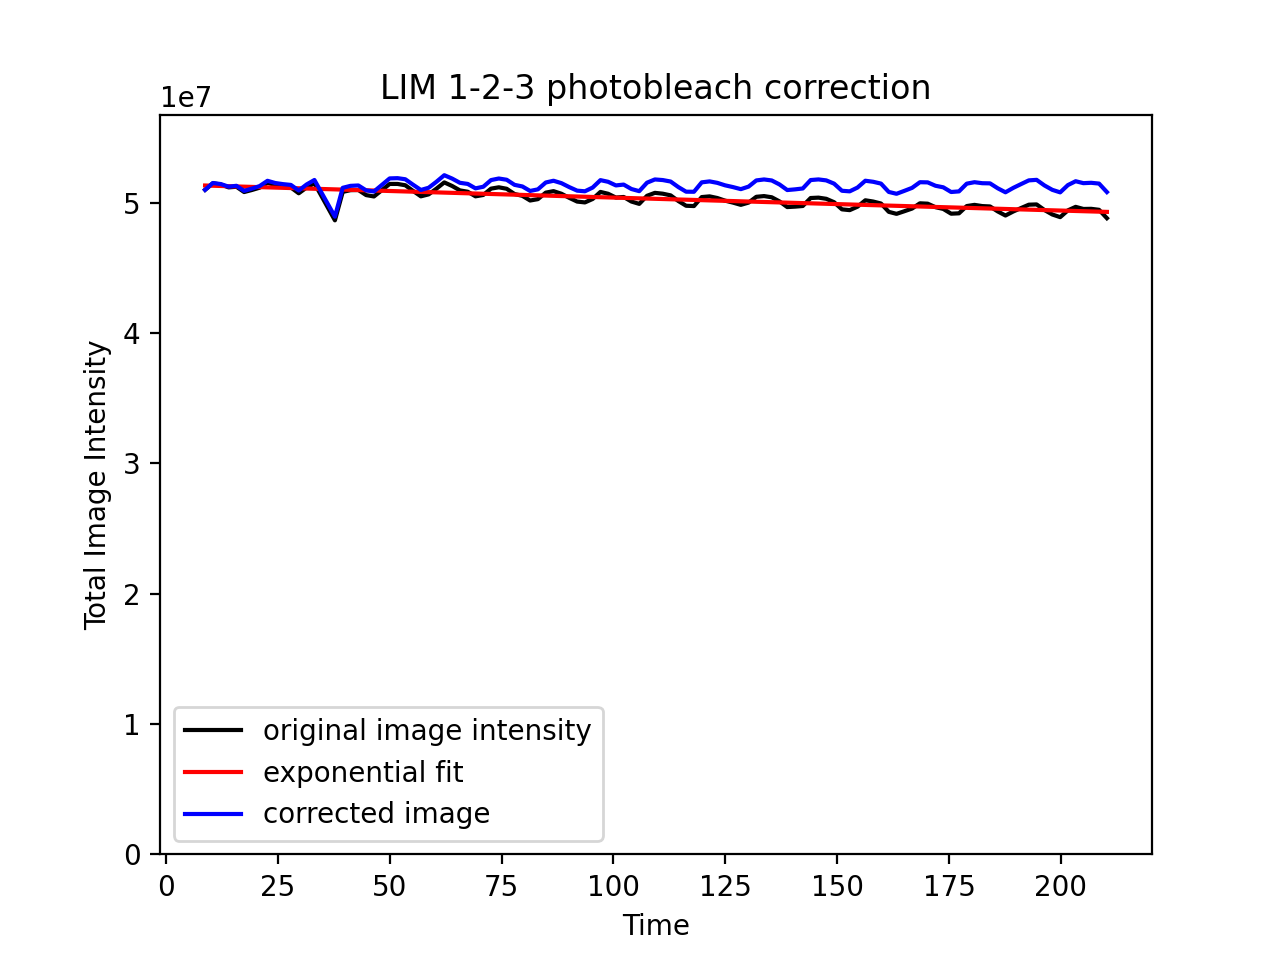

<IPython.core.display.Javascript object>


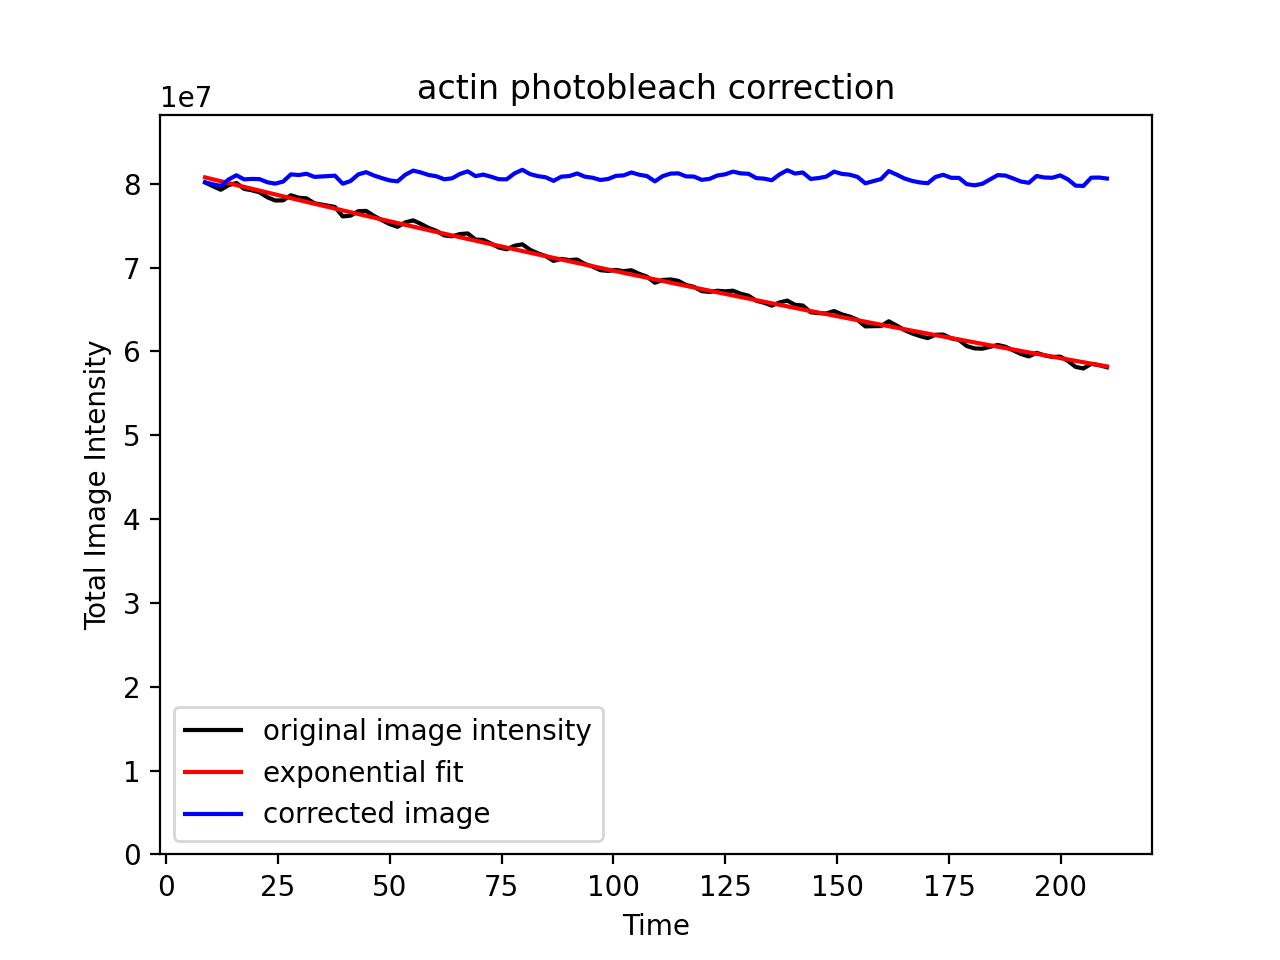

/Users/patrickoakes/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: UserWarning: LA_example/LIM 1-2-3 LA 9_XY1591840029_Z0_T000_C0_cellmask.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


<IPython.core.display.Javascript object>


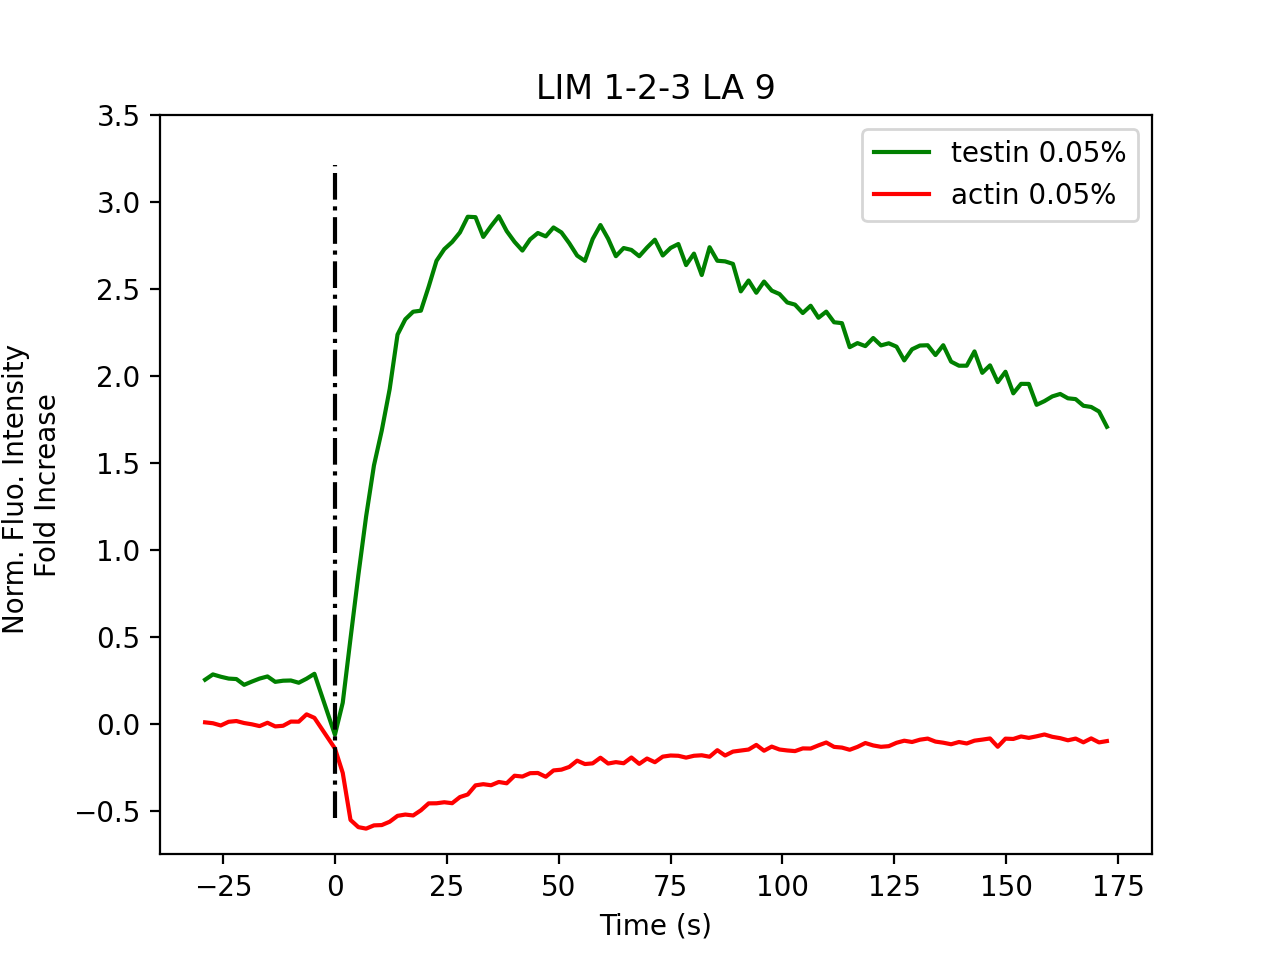

<IPython.core.display.Javascript object>


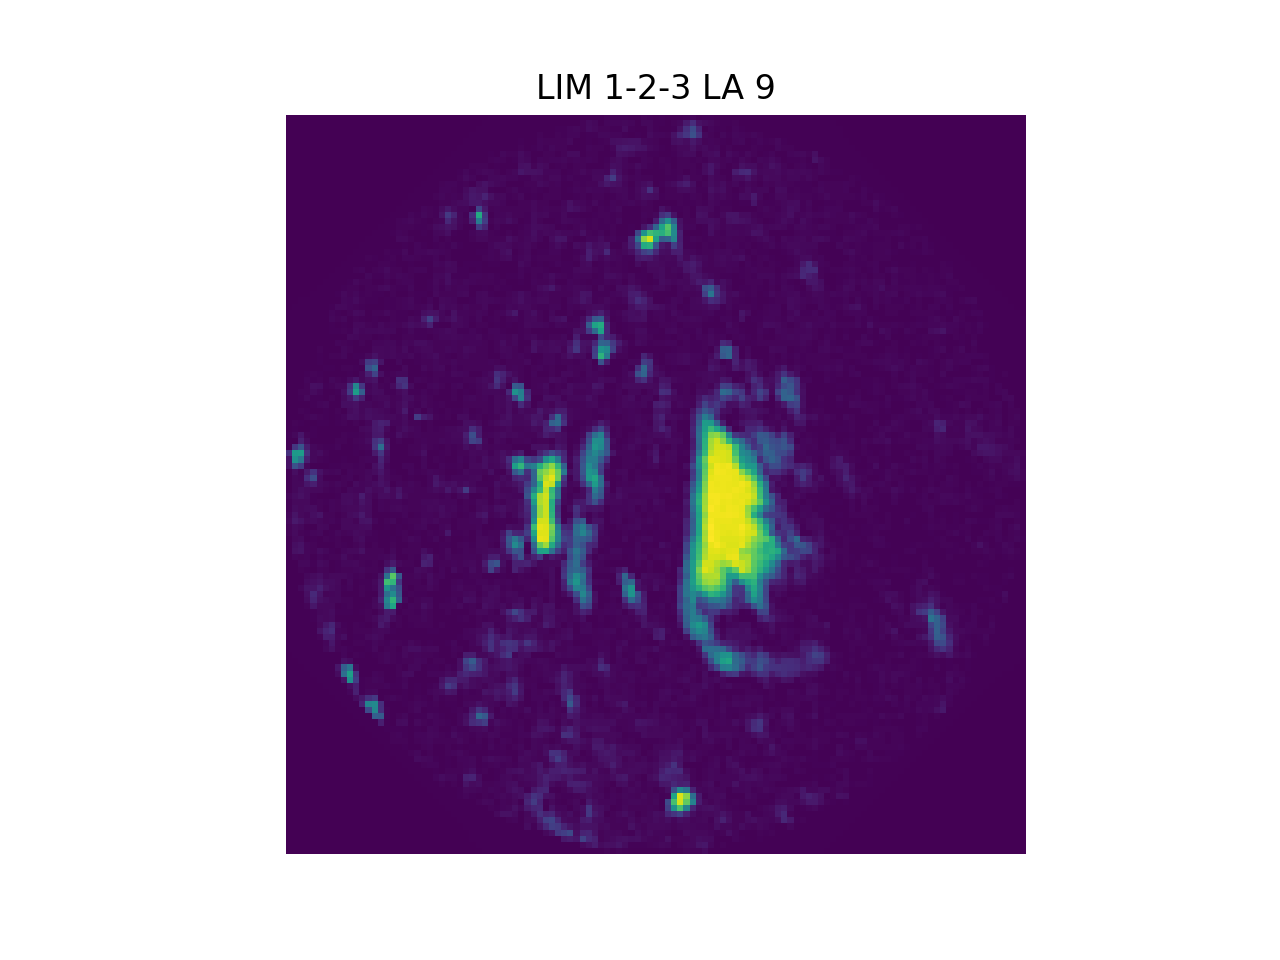

/Users/patrickoakes/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: UserWarning: LA_example/LIM 1-2-3 LA 9_XY1591840029_Z0_T000_C0_mask_pts.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
/Users/patrickoakes/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: UserWarning: LA_example/LIM 1-2-3 LA 9_XY1591840029_Z0_T000_C0_mask_pts.tif is a low contrast image
/Users/patrickoakes/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: UserWarning: LA_example/LIM 1-2-3 LA 9_XY1591840029_Z0_T000_C0_overlay_mask_pts.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
/Users/patrickoakes/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: UserWarning: LA_example/LIM 1-2-3 LA 9_XY1591840029_Z0_T000_C0_overlay_mask_pts.tif is a low contrast image
/Users/patrickoakes/opt/

In [3]:
# for a normal movie with testin construct in channel 0, actin in channel 1

testin_val, testin_peaktrace, testin_avetrace, testin_mintrace, testin_bleach = [], [], [], [], []
actin_val, actin_peaktrace, actin_avetrace, actin_mintrace, actin_bleach = [], [], [], [], []
zyxin_val, zyxin_peaktrace, zyxin_avetrace, zyxin_mintrace, zyxin_bleach = [], [], [], [], []
testin_peaktrace_std, actin_peaktrace_std, zyxin_peaktrace_std, testin_avetrace_std, actin_avetrace_std, zyxin_avetrace_std, = [], [], [], [], [], []
peak_time, moviename = [], []
overlay_list, ablation_angle_list = [], []

# set the threshhold value to use for the mask
thresh_value = 0.05

# define ROI properties
ROI_radius = 20
ROI_multiple = 1

# set base directory
if file_list_LA_c0[0].find('/') == -1:
    base_folder = ''
else:
    base_folder = file_list_LA_c0[0][:file_list_LA_c0[0].rfind('/')] + '/'

for filename in file_list_LA_c0:
    
    # read in the image stack
    imstack = io.imread(filename)

    # split image stack based on slidebook tif
    if imstack.shape[-1] == 3:
        c0 = imstack[:,:,:,0].astype('float32')  # convert to float so that we don't have issues if our corrected values go negative
        c1 = imstack[:,:,:,1].astype('float32')
        c2 = imstack[:,:,:,2].astype('float32')

    else:
        # split stack into the channels
        c0 = imstack[:,0,:,:].astype('float32')  # convert to float so that we don't have issues if our corrected values go negative
        c1 = imstack[:,1,:,:].astype('float32')

    # pull out experimental details from the XML file
    exp_details = parse_XML(filename + '.xml')

    # construct
    construct = filename[filename.find('/') + 1:filename.rfind('LA')-1]

    # set the ROI radius as fixed to be consistent
    exp_details['ROI_radius'] = ROI_radius
    exp_details['ROI_multiple'] = ROI_multiple

    # flat field and darkfield correct the image stacks
    c0 = flat_field_correct_image(c0,exp_details['camera'], exp_details['objective_magnification'], '488')
    c1 = flat_field_correct_image(c1,exp_details['camera'], exp_details['objective_magnification'], '561short')
    if imstack.shape[-1] == 3:
        c2 = flat_field_correct_image(c2,exp_details['camera'], exp_details['objective_magnification'], '640long')

    # correct for photobleaching
    start_frame = 5   # choose a frame to start from in the image series - basically allows you to skip the first frame or two
    c0, c0_bleach_params, c0_inten, c0_bleach_correction = photobleach_correct(c0[start_frame:], exp_details['time_pts'][start_frame:],fit_type = "single", title = construct, show_figure = True)
    #     plt.gcf().savefig(exp_details['base_folder'] + '/' + filename[:-4] + '_c0_bleach.png', format='png', dpi=300)
    plt.gcf().savefig(filename[:-4] + '_c0_bleach.png', format='png', dpi=300)
    c1, c1_bleach_params, c1_inten, c1_bleach_correction = photobleach_correct(c1[start_frame:], exp_details['time_pts'][start_frame:],fit_type = "single", title = 'actin',show_figure = True)
    #     plt.gcf().savefig(exp_details['base_folder'] + '/' + filename[:-4] + '_c1_bleach.png', format='png', dpi=300)
    plt.gcf().savefig(filename[:-4] + '_c1_bleach.png', format='png', dpi=300)
    if imstack.shape[-1] == 3:
        c2, c2_bleach_params, c2_inten, c2_bleach_correction = photobleach_correct(c2[start_frame:], exp_details['time_pts'][start_frame:],fit_type = "single", show_figure = True)
        #     plt.gcf().savefig(exp_details['base_folder'] + '/' + filename[:-4] + '_c1_bleach.png', format='png', dpi=300)
        plt.gcf().savefig(filename[:-4] + '_c2_bleach.png', format='png', dpi=300)


    # correct time_pts and ablation point in exp_details
    exp_details['ablation_timepoint'] = exp_details['ablation_timepoint'] - start_frame 
    exp_details['time_pts'] = exp_details['time_pts'][start_frame:]
    exp_details['time_pts'] = exp_details['time_pts'] - exp_details['time_pts'][exp_details['ablation_timepoint']]

    # register stacks to account for any shifting
    c0, shift_coordinates = register_image_stack(c0)
    c1 = shift_image_stack(c1, shift_coordinates)

    # correct for any pixels less than zero (numpy wraps them around when converted to 16 bit)
    c0[c0 < 0] = 0
    c1[c1 < 0] = 0
    
    # convert everything back to a uint16 image
    c0 = c0.astype('uint16')
    c1 = c1.astype('uint16')
    
    # if there's a 3rd channel register it, correct for pixels less than zero, change to uint16
    if imstack.shape[-1] == 3:
        c2 = shift_image_stack(c2, shift_coordinates)
        c2[c2 < 0] = 0
        c2 = c2.astype('uint16')

    # make a cell mask outline (to make sure we only look at point in the original outline of the cell)
    cellmask = cellmask_threshold(c0[0])
    
    # make the mask for the ablation region and the overlay (set to 3 times the ablation ROI)
    ROI_mask, bg = make_ablation_ROI(exp_details, ROI_multiple = exp_details['ROI_multiple'], ROI_radius = exp_details['ROI_radius'])
    overlay_mask, bg = make_ablation_ROI(exp_details, ROI_multiple = 3, ROI_radius = exp_details['ROI_radius'])

    # multiply those masks by the cellmask to make sure we are only looking for points inside the cell
    ROI_mask = ROI_mask * cellmask
    overlay_mask = overlay_mask * cellmask
    
    # round the mask to integers to make sure there are no holes
    ROI_mask = np.rint(ROI_mask).astype('bool')
    overlay_mask = np.rint(overlay_mask).astype('bool')
    
    # save the mask
    #     io.imsave(exp_details['base_folder'] + '/' + filename[:-4] + '_cellmask.tif', mask)
    io.imsave(filename[:-4] + '_cellmask.tif', cellmask)
    bg = np.rint(bg).astype('bool')

    # do the intensity analysis - run it twice if there are three channels otherwise set zyxin channel to 0
    if imstack.shape[-1] == 3:
        zyxin_peak_inten, zyxin_ave_inten, peak_zyxin, testin_peak_inten, testin_ave_inten, peak_testin, peak_pt, ROI_mask_pts, overlay_mask_pts, zyxin_peak_std, testin_peak_std, zyxin_ave_std, testin_ave_std = intensity_analysis(c1, c0, ROI_mask, overlay_mask, thresh_value, exp_details)
        zyxin_peak_inten, zyxin_ave_inten, peak_zyxin, act_peak_inten, act_ave_inten, peak_actin, peak_pt, ROI_mask_pts, overlay_mask_pts, zyxin_peak_std, act_peak_std, zyxin_ave_std, act_ave_std = intensity_analysis(c1, c2, ROI_mask, overlay_mask, thresh_value, exp_details)
    else:
        testin_peak_inten, testin_ave_inten, peak_testin, act_peak_inten, act_ave_inten, peak_actin, peak_pt, ROI_mask_pts, overlay_mask_pts, testin_peak_std, act_peak_std, testin_ave_std, act_ave_std = intensity_analysis(c0, c1, ROI_mask, overlay_mask, thresh_value, exp_details)
        zyxin_peak_inten, zyxin_ave_inten, peak_zyxin, zyxin_peak_std, zyxin_ave_std, c2_bleach_params = [0] * 6

    # find the ablation mask
    ablation_mask, ablation_angle = find_ablation_mask(filename, exp_details)

    # add them back to the exp_details 
    exp_details['ablation_angle'] = ablation_angle
    exp_details['ablation_mask'] = ablation_mask
    exp_details['filename'] = filename

    # sum the mask points in the overlay mask
    overlay_mask_sum = np.sum(overlay_mask_pts, axis=0)
    overlay_mask_sum_cropped = overlay_mask_sum[(exp_details['ROI_center_row']-60):(exp_details['ROI_center_row']+61),(exp_details['ROI_center_col']-60):(exp_details['ROI_center_col']+61)]
    spatial_frequency_map = rotate(overlay_mask_sum_cropped, exp_details['ablation_angle'], order=3)
    
    # plot the spatial frequency map
    plt.figure()
    plt.imshow(spatial_frequency_map)
    plt.axis('off')
    plt.title(exp_details['file'].split('/')[-1].split('_')[0])
    plt.show()

    # save all the various images
    io.imsave(filename[:-4] + '_mask_pts.tif', ROI_mask_pts)
    io.imsave(filename[:-4] + '_overlay_mask_pts.tif', overlay_mask_pts)
    io.imsave(filename[:-4] + '_ablationmask.tif', ablation_mask.astype('bool'))
    io.imsave(filename[:-4] + '_spatial_frequency_map.tif', spatial_frequency_map)

    # add everything to lists for the images in the file list
    testin_val.append(peak_testin)
    testin_peaktrace.append(testin_peak_inten)
    testin_peaktrace_std.append(testin_peak_std)
    testin_avetrace.append(testin_ave_inten)
    testin_avetrace_std.append(testin_ave_std)
    testin_bleach.append(c0_bleach_params)
    actin_val.append(peak_actin)
    actin_peaktrace.append(act_peak_inten)
    actin_peaktrace_std.append(act_peak_std)
    actin_avetrace.append(act_ave_inten)
    actin_avetrace_std.append(act_ave_std)
    actin_bleach.append(c1_bleach_params)
    zyxin_val.append(peak_zyxin)
    zyxin_peaktrace.append(zyxin_peak_inten)
    zyxin_peaktrace_std.append(zyxin_peak_std)
    zyxin_avetrace.append(zyxin_ave_inten)
    zyxin_avetrace_std.append(zyxin_ave_std)
    zyxin_bleach.append(c2_bleach_params)
    peak_time.append(peak_pt)
    moviename.append(filename.split('/')[-1].split('_')[0])
    overlay_list.append(overlay_mask_sum_cropped)
    ablation_angle_list.append(ablation_angle)
# end of for loop
    
# make a dictionary of all the data collected
data_dict = {
    'testin_values' : testin_val,
    'actin_values' : actin_val,
    'peak_time' : peak_time,
    'testin_bleach' : testin_bleach,
    'actin_bleach' : actin_bleach,
    'testin_ave_traces' : testin_avetrace,
    'testin_ave_traces_std' : testin_avetrace_std,
    'testin_peak_traces' : testin_peaktrace,
    'testin_peak_traces_std' : testin_peaktrace_std,
    'actin_ave_traces' : actin_avetrace,
    'actin_ave_traces_std' : actin_avetrace_std,
    'actin_peak_traces' : actin_peaktrace,
    'actin_peak_traces_std' : actin_peaktrace_std,
    'zyxin_ave_traces' : zyxin_avetrace,
    'zyxin_ave_traces_std' : zyxin_avetrace_std,
    'zyxin_peak_traces' : zyxin_peaktrace,
    'zyxin_peak_traces_std' : zyxin_peaktrace_std,
    'file_name' : moviename,
    'overlays' : overlay_list,
    'ablation_angle' : ablation_angle_list
}
# convert the dictionary to a dataframe
data_testin = pd.DataFrame(data_dict)
# make the filename to save the dataframe
# data_filename = base_folder + base_folder.split('/')[-2] + '_alldata.h5'
data_filename = filename[:-4] + '_' + construct +'_alldata.h5'
# save the dataframe
data_testin.to_hdf(data_filename, key='testin', mode='w')
